# VANGUARD AB TEST


## METADATA HELP

This comprehensive set of fields will guide your analysis, helping you unravel the intricacies of client behavior and preferences.

- **client_id**: Every client’s unique ID.
- **variation**: Indicates if a client was part of the experiment.
- **visitor_id**: A unique ID for each client-device combination.
- **visit_id**: A unique ID for each web visit/session.
- **process_step**: Marks each step in the digital process.
- **date_time**: Timestamp of each web activity.
- **clnt_tenure_yr**: Represents how long the client has been with Vanguard, measured in years.
- **clnt_tenure_mnth**: Further breaks down the client’s tenure with Vanguard in months.
- **clnt_age**: Indicates the age of the client.
- **gendr**: Specifies the client’s gender.
- **num_accts**: Denotes the number of accounts the client holds with Vanguard.
- **bal**: Gives the total balance spread across all accounts for a particular client.
- **calls_6_mnth**: Records the number of times the client reached out over a call in the past six months.
- **logons_6_mnth**: Reflects the frequency with which the client logged onto Vanguard’s platform over the last six months.


In [ ]:
%load_ext autoreload
%autoreload 2 

In [124]:
from cleaning import *
from mining import *
from db_handling import *
from analysis import *
import pandas as pd
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# Load environment variables
load_dotenv()

### Load Configuration

In [ ]:
# Load config.yaml
config = parse_config()

## Data Mining

In [127]:
# Creates a dictionary of all imported dataframes
dataframes = { name:import_data_from_config(config, name) for name in config['tables']}

## Data Cleaning

In [128]:
#TODO: don't impose categories?

In [129]:
# Rename columns
dataframes = rename_columns(dataframes, config)

In [130]:
# Select columns
dataframes = select_columns(dataframes, config)

In [ ]:
display_dataFrames(dataframes,'head','shape')

### Separation

In [ ]:
client_df = dataframes['clients']
experiment_df = dataframes['experiment']
visits_df = dataframes['visits']
display (client_df, experiment_df, visits_df)

In [ ]:
# drop the nulls from clients, but keep the list of the drops

nulls_client_id = client_df[client_df.isna().any(axis=1)]['client_id']
nulls_client_id

In [ ]:
client_df = client_df.dropna(axis=0)
client_df

In [ ]:
display(experiment_df['variation'].value_counts(dropna = False))
# keep NaN for general analysis of clients, but drop them from everywhere for test analysis

In [ ]:
# client_df, experiment_df, visit_df -> for general analysis
# new_client_df, new_experiment_df, new_visit_dfn -> for test/control analysis   experiment_df_null = 
nulls_in_experiment = experiment_df[experiment_df.isna().any(axis=1)]['client_id']
nulls_in_experiment

In [ ]:
# new df removing client ID that are null in experiment

display(experiment_df.count())
new_experiment_df = experiment_df[~experiment_df['client_id'].isin(nulls_in_experiment)]
display(new_experiment_df.count())

new_experiment_df = new_experiment_df[~new_experiment_df['client_id'].isin(nulls_client_id)]
display(new_experiment_df.count())
display(new_experiment_df.isna().sum())



In [ ]:
display(visits_df)
new_visits_df = visits_df[~visits_df['client_id'].isin(nulls_in_experiment)]
display(new_visits_df)
display(new_visits_df.isna().sum())

In [ ]:
display(client_df)
new_client_df = client_df[~client_df['client_id'].isin(nulls_in_experiment)]
display(new_client_df)

### End separation

In [140]:
dataframes['clients'] = new_client_df.copy()
dataframes['experiment'] = new_experiment_df.copy()
dataframes['visits'] = new_visits_df.copy()

In [141]:
# Data Categorizing
dataframes = clean_categorical_data(dataframes, config)

In [142]:
#Convert types
dataframes = convert_types(dataframes, config)

In [ ]:
display_dataFrames(dataframes, 'head', 'shape', 'cat_count')

In [144]:
client_df = dataframes['clients']
experiment_df = dataframes['experiment']
visits_df = dataframes['visits']


### SQL EXPORT

In [145]:
if config['refresh_db']:

    db_password = os.getenv('SQL_PASSWORD')

    # Create database if it doesn't exist
    engine = create_db(db_password, config)

    # Export tables to database if refresh is set to true
    export_dataframes_to_sql(engine, dataframes)

    # Import data from database
    dataframes = import_all_tables_from_sql(engine)

### Local Caching

In [ ]:
""" # Save files locally in an untracked folder
export_dataframes_to_csv(dataframes) """

In [ ]:
#TODO CAREFUL DATA WONT BE PROPERLY CATEGORIZED / TYPED run after : convert_types(dataframes, config)
""" clients_df = pd.read_csv('data/cleaned/clients.csv')
experiment_df = pd.read_csv('data/cleaned/experiment.csv')
visits_df = pd.read_csv('data/cleaned/visits.csv') """

## CLEAN FRAMES

In [ ]:
display('clients :',client_df, 'experiment :',experiment_df, 'visits :',visits_df)

experiment_df['variation'].value_counts()


## Data Exploration

### Merge frames

In [ ]:
# Added variation column to visits for easier analysis
visits_variations = visits_df.merge(experiment_df, on='client_id', how='inner')
display(visits_variations)

In [ ]:
# Merge clients and visits for demographic analysis
visits_variations = visits_variations.merge(client_df, on='client_id', how='inner')
display(visits_variations)

### Sort visits by time

In [ ]:
# sort by visit_id and date_time to see the process steps in order
visits_variations = visits_variations.sort_values(by=['visit_id', 'date_time'], ascending=[True, True])
display(visits_variations)

## OUTLIERS

### Time taken

In [ ]:
visits_variations['time_taken'] = visits_variations.groupby('visit_id')['date_time'].diff().dt.total_seconds()
visits_variations['time_taken'] = visits_variations['time_taken'].fillna(0)

display(visits_variations)

In [ ]:
# add a column to show the total time taken for each visit_id
visits_variations['total_time_taken'] = visits_variations.groupby('visit_id')['time_taken'].transform('sum')
display(visits_variations)

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='variation', y='total_time_taken', data=visits_variations)
plt.xlabel('Variation')
plt.ylabel('Total Time Taken (seconds)')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=visits_variations, x='total_time_taken', kde=True, bins=300)
plt.xlabel('Total Time Taken (seconds)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
variations_outliers = tukeys_test_outliers(visits_variations['total_time_taken'], method="show")
display(variations_outliers)
display(variations_outliers.describe())

visits_variations = visits_variations[~visits_variations['total_time_taken'].isin(variations_outliers)]
display(visits_variations)
display(visits_variations.describe())

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=visits_variations, x='total_time_taken', kde=True, bins=50)
plt.xlabel('Total Time Taken (seconds)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='variation', y='total_time_taken', data=visits_variations)
plt.xlabel('Variation')
plt.ylabel('Total Time Taken (seconds)')
plt.show()

visits_variations['total_time_taken'].describe()

### Correlation matrix

In [ ]:
# select only the happy paths confirmed steps
confirmed_steps = visits_variations[visits_variations['process_step'] == 'confirm']

# Select numerical columns
numerical_data = confirmed_steps.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Display the correlation matrix
display(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Count visits

In [ ]:
# Total number of visits per variation to calculate the success rate later
number_of_visits = visits_variations.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits)

### Time taken

In [ ]:
# Average total time taken per variation
average_total_time_ = visits_variations.groupby('variation')['total_time_taken'].mean()
display(average_total_time_)

## Happy Path

In [162]:
# function to filter visits with our happy path
def filter_visits_with_happy_path(df):
    def check_sequence(group):
        steps = list(group['process_step'])
        return steps == ['start', 'step_1', 'step_2', 'step_3', 'confirm']

    df_filtered = df.groupby('visit_id').filter(check_sequence)
    return df_filtered


In [ ]:
happy_paths = filter_visits_with_happy_path(visits_variations)
display(happy_paths)

In [ ]:
# Total number of success per variation
number_of_successes = happy_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_successes)

In [ ]:
# calculate the success rate per variation
success_rate = number_of_successes / number_of_visits
display(success_rate)

## Confused Path

In [166]:
# function to filter out visits with start->confirm but no happy path in between them
def filter_non_happy_path_visits(df):
    def check_non_consecutive(group):
        steps = list(group['process_step'])
        if steps[0] == 'start' and steps[-1] == 'confirm':
            if steps != ['start', 'step_1', 'step_2', 'step_3', 'confirm']:
                return True
        return False

    df_filtered = df.groupby('visit_id').filter(check_non_consecutive)
    return df_filtered

In [ ]:
non_happy_paths = filter_non_happy_path_visits(visits_variations)
display(non_happy_paths)

In [ ]:
number_of_visits_non_happy = non_happy_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits_non_happy)

In [ ]:
success_rate_non_happy = number_of_visits_non_happy / number_of_visits
display(success_rate_non_happy)
# proportion of lost people is greater in test group.

## Error Path

In [ ]:
without_happy_path = visits_variations[~visits_variations['visit_id'].isin(happy_paths['visit_id'])]

error_paths = without_happy_path[~without_happy_path['visit_id'].isin(non_happy_paths['visit_id'])]
display(error_paths)

In [ ]:
number_of_visits_error_path = error_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits_error_path)

In [ ]:
success_rate_error_paths = number_of_visits_error_path / number_of_visits
display(success_rate_error_paths)

In [ ]:
#TODO merge success paths ?

### Count check

True

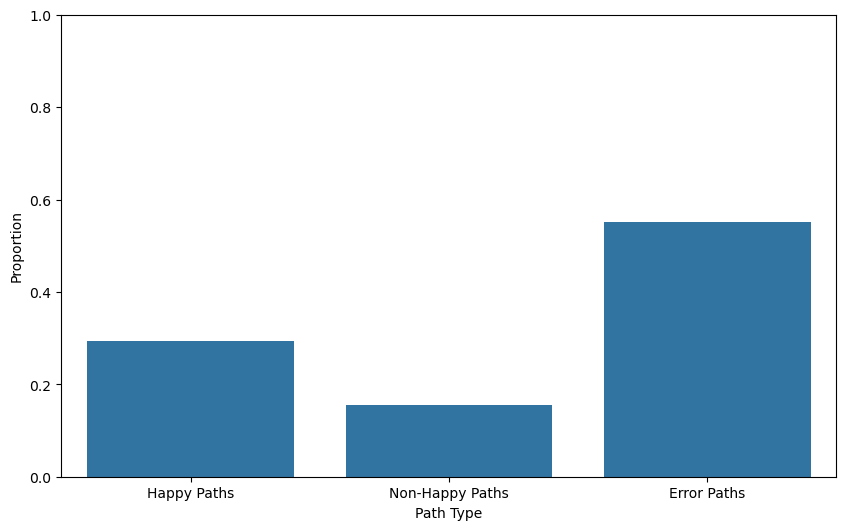

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_64792/2136028899.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Happy Paths': happy_paths.groupby('variation')['visit_id'].nunique(),
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_64792/2136028899.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Non-Happy Paths': non_happy_paths.groupby('variation')['visit_id'].nunique(),
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_64792/2136028899.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

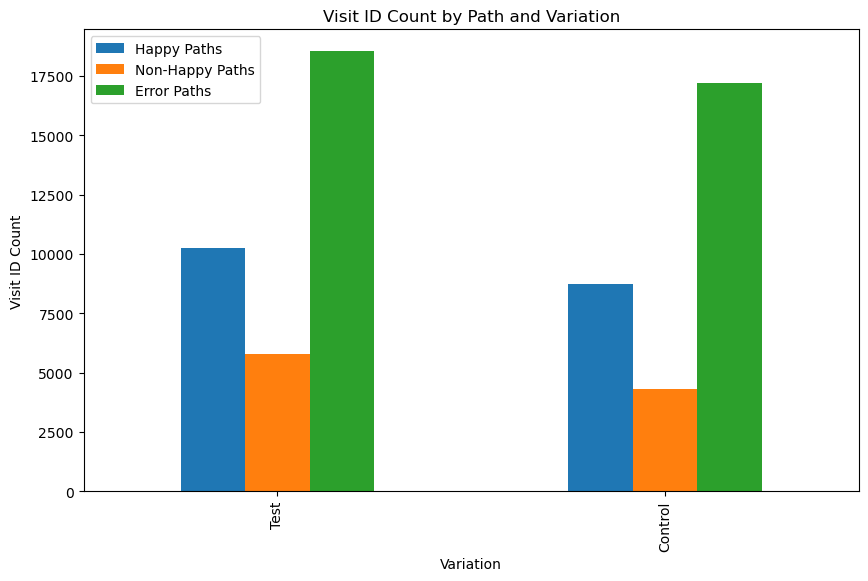

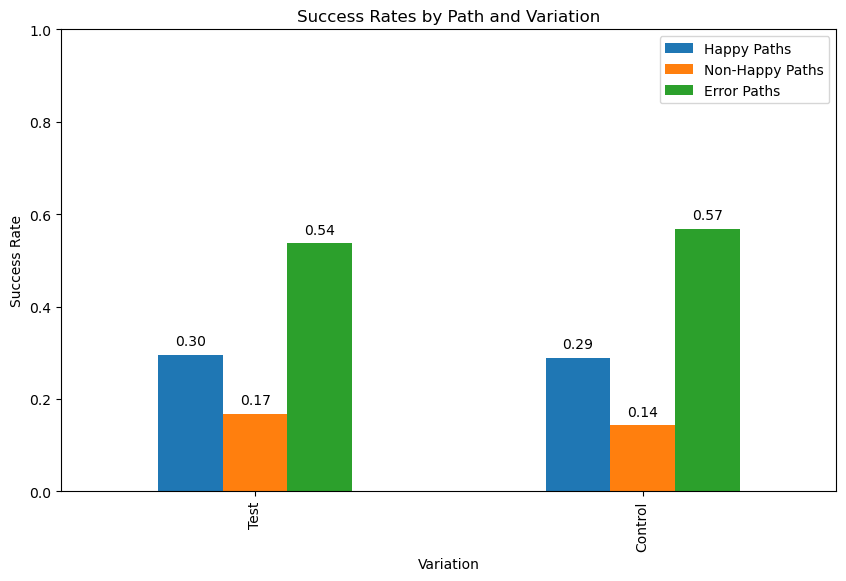

In [184]:
unique_visit_count = visits_variations['visit_id'].nunique()
unique_happy_paths_count = happy_paths['visit_id'].nunique()
unique_non_happy_paths_count = non_happy_paths['visit_id'].nunique()
unique_error_paths_count = error_paths['visit_id'].nunique()
display((unique_happy_paths_count+unique_non_happy_paths_count+unique_error_paths_count) == unique_visit_count)

proportions = {
    'Happy Paths': unique_happy_paths_count / unique_visit_count,
    'Non-Happy Paths': unique_non_happy_paths_count / unique_visit_count,
    'Error Paths': unique_error_paths_count / unique_visit_count
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(proportions.keys()), y=list(proportions.values()))
plt.xlabel('Path Type')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.show()


path_counts_by_variation = {
    'Happy Paths': happy_paths.groupby('variation')['visit_id'].nunique(),
    'Non-Happy Paths': non_happy_paths.groupby('variation')['visit_id'].nunique(),
    'Error Paths': error_paths.groupby('variation')['visit_id'].nunique()
}

path_counts_df = pd.DataFrame(path_counts_by_variation)
path_counts_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Variation')
plt.ylabel('Visit ID Count')
plt.title('Visit ID Count by Path and Variation')
plt.show()

success_rates_by_path = {
    'Happy Paths': number_of_successes / number_of_visits,
    'Non-Happy Paths': number_of_visits_non_happy / number_of_visits,
    'Error Paths': number_of_visits_error_path / number_of_visits
}

success_rates_df = pd.DataFrame(success_rates_by_path)
ax = success_rates_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Variation')
plt.ylabel('Success Rate')
plt.title('Success Rates by Path and Variation')
plt.ylim(0, 1)

# Label the bars with the values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


## Analysis

In [ ]:
# PROPORTION Z TEST ----Happy Paths---- Proportion of successes is greater in Test group than in Control group
# H0: Proportion of complete steps in TEST group <= Proportion of complete steps in CONTROL group
# H1: Pt > Pc
alpha = 0.05

successes = [number_of_successes['Test'], number_of_successes['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

proportions_ztest(successes, just_visits, alternative = "larger")

In [ ]:
# PROPORTION Z TEST ----Non Happy Paths----
# H0: Proportion of complete steps in TEST group <= Proportion of complete steps in CONTROL group
# H1: Pt > Pc
alpha = 0.05

successes = [number_of_visits_non_happy['Test'], number_of_visits_non_happy['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

proportions_ztest(successes, just_visits, alternative = "larger")

In [ ]:
# PROPORTION Z TEST ----Error Paths---- 
# H0: Proportion of visits in TEST group >= Proportion of visits in CONTROL group
# H1: Pt < Pc
alpha = 0.05

successes = [number_of_visits_error_path['Test'], number_of_visits_error_path['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

proportions_ztest(successes, just_visits, alternative = "smaller")

### T-Test for total time

In [ ]:
# TWO SAMPLE T TEST ---- Average total_time of success is smaller in Test group than in Control group
import scipy.stats as st
# H0: average time it took to complete steps in test group is greater or equal to one in control group 
#       (Mean_time_test>=Mean_time_control)
# H1: average time it took to complete steps is less in test group than in control group 
#       (Mean_time_test<Mean_time_control)
alpha=0.05
df_test = happy_paths[happy_paths['variation']=='Test']['total_time_taken']
df_control = happy_paths[happy_paths['variation']=='Control']['total_time_taken']
st.ttest_ind(df_test,df_control, equal_var=False, alternative = 'less')

In [ ]:
average_time_per_variation = happy_paths.groupby('variation').agg({'total_time_taken': 'mean'})
average_time_per_variation

In [ ]:
# average total time without outliers
avg_total_time = happy_paths['total_time_taken'].mean()
display(avg_total_time)

In [180]:
#TODO: consider binning / pd.cut / qcut for numerical data
#TODO: correlation matrix
#TODO: tukeys_test_outliers

In [181]:
# check back and forth between steps, lost?
# 

## Visualizations

## Conclusions